# 모듈 불러오기

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

import scipy
from scipy.ndimage import gaussian_filter1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.optim import *
from torch.optim.lr_scheduler import *

import os 
import glob
import cv2
import itertools
from copy import deepcopy
from fast_pytorch_kmeans import KMeans

from collections import namedtuple
from torch.nn import parameter
import torch.nn.utils.prune as prune

from dataloader import *
from model import *

# Train

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

conv1d_dim1 = 32
conv1d_dim2 = 64
conv1d_dim3 = 128
dense_dim = 256

learning_rate = 0.001
n_epochs = 2000

criterion_mse = nn.MSELoss()

In [5]:
# 경로 입력 및 아이디 추출
random_seed = 77
np.random.seed(random_seed) # numpy
random.seed(random_seed) # random

file_path = "/home/taeoowl/gait/data/total/"
data_path = glob.glob(file_path + '*')
name = []
for file_name in data_path:
    folder_name = os.path.split(file_name)[1][:7]
    name += [folder_name]
    
id_name = np.unique(name)

# trn/val/tst으로 사용할 id 추출
# 남녀 각각 2명씩 보폭이 큰 사람(Q1)과 작은 사람(Q3)을 기준
test_id = np.array(['IF03014', 'IF00041', 'IM02040', 'IM98049'])

id_name_trnval = np.setdiff1d(id_name, test_id)
valid_id = np.random.choice(id_name_trnval, size=4, replace=False)

train_id = np.setdiff1d(id_name, np.hstack([test_id, valid_id]))

print('Train ID : {}\n Valid ID {}'.format(train_id, valid_id))

Train ID : ['IF00017' 'IF00024' 'IF01020' 'IF01045' 'IF01047' 'IF02035' 'IF03027'
 'IF99008' 'IF99013' 'IF99030' 'IF99032' 'IM01006' 'IM01029' 'IM03011'
 'IM03048' 'IM96018' 'IM96033' 'IM97015' 'IM98009' 'IM98026' 'IM98036'
 'IM98042' 'IM98050' 'IM99007' 'IM99010' 'IM99012' 'IM99021' 'IM99025'
 'IM99037']
 Valid ID ['IF00034' 'IM98019' 'IF03039' 'IF94031']


In [28]:
# seed 고정
torch.manual_seed(random_seed) # torch 
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True # cudnn
torch.backends.cudnn.benchmark = False # cudnn
np.random.seed(random_seed) # numpy
random.seed(random_seed) # random



train_dataset_R = Gait_Dataset_Salted(file_path, train_id, right=True)
train_dataset_L = Gait_Dataset_Salted(file_path, train_id, right=False)

valid_dataset_R = Gait_Dataset_Salted(file_path, valid_id, right=True)
valid_dataset_L = Gait_Dataset_Salted(file_path, valid_id, right=False)

train_dataset = torch.utils.data.ConcatDataset([train_dataset_R, train_dataset_L])
valid_dataset = torch.utils.data.ConcatDataset([valid_dataset_R, valid_dataset_L])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                       batch_size=128,
                                       shuffle=True,
                                       worker_init_fn=np.random.seed(42))
val_loader = torch.utils.data.DataLoader(valid_dataset,
                                         batch_size=128,
                                         shuffle=False)

print('Dataloader Load Complete')



model = Encoder(conv1d_dim1, conv1d_dim2, conv1d_dim3, dense_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Early Stopping을 위한 변수
best = 10000
converge_cnt = 0
best_MAE = 0
best_corr = 0
best_epoch = 0

# Run Training loop
for epoch in range(0, n_epochs) :
    # Set current loss value 
    tot_trn_loss = 0.0

    # Train Mode
    model.train()

    # Iterate over the DataLoader for training data 
    for i, data in enumerate(train_loader) :
        inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
        inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float()
        inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        # 순전파 
        outputs = model(inputs_acc, inputs_gyr, inputs_prs)

        # Loss 계산
        loss = criterion_mse(outputs, stride_length)


        # 기울기 초기화 
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 옵티마이저
        optimizer.step()


        # Print statistics
        tot_trn_loss += loss.item()

    # Evaluation Mode
    model.eval()

    tot_val_loss = 0
    tot_val_MAE = 0
    val_epoch_loss = []

    with torch.no_grad() :
        for i, data in enumerate(val_loader):
            inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
            inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float()
            inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

            stride_length = stride_length.reshape(-1, 1)
            stride_length = stride_length.to(device)

            # 순전파 
            outputs = model(inputs_acc, inputs_gyr, inputs_prs)

            # Loss 계산
            loss = criterion_mse(outputs, stride_length)

            tot_val_loss += loss.item()
            tot_val_MAE += torch.sum(torch.abs(outputs - stride_length)) / len(stride_length)


    # Epoch 별 Loss
    trn_loss = tot_trn_loss / len(train_loader)
    val_loss = tot_val_loss / len(val_loader)
    MAE = tot_val_MAE / len(val_loader)    

    print("Epoch : {}/{}, Train Loss : {:.3f}, Valid Loss {:.3f}, MAE {:.3f}".format(epoch+1, n_epochs,
                                                                                       trn_loss, val_loss, MAE))

    # Early Stopping
    if val_loss < best:
        best = np.mean(val_loss)
        best_MAE = MAE
        best_epoch = epoch+1
        
        checkpoint = {
            'state_dict': model.state_dict(),  # 모델 가중치
            'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 상태
            'epoch': best_epoch,  # 에폭 정보
            'loss': best  # 마지막 손실 값
}
        torch.save(checkpoint, './model/pruning/model_origin.pth')  
        print('Best Valid Loss {:.4f}'.format(best))
        converge_cnt = 0
    else:
        converge_cnt += 1

    if converge_cnt > 50:
        print('Early stopping')
        print('Best Result : Epoch {}, Valid Loss {:.3f}, MAE {:.3f}'.format(best_epoch, best, best_MAE))
        break



Dataloader Load Complete
Epoch : 1/2000, Train Loss : 4025.449, Valid Loss 3172.665, MAE 55.104
Best Valid Loss 3172.6653
Epoch : 2/2000, Train Loss : 226.493, Valid Loss 382.221, MAE 14.612
Best Valid Loss 382.2212
Epoch : 3/2000, Train Loss : 112.556, Valid Loss 211.437, MAE 12.987
Best Valid Loss 211.4369
Epoch : 4/2000, Train Loss : 99.351, Valid Loss 149.094, MAE 11.024
Best Valid Loss 149.0940
Epoch : 5/2000, Train Loss : 79.809, Valid Loss 162.825, MAE 11.592
Epoch : 6/2000, Train Loss : 60.658, Valid Loss 84.662, MAE 7.992
Best Valid Loss 84.6622
Epoch : 7/2000, Train Loss : 46.926, Valid Loss 108.191, MAE 8.975
Epoch : 8/2000, Train Loss : 42.095, Valid Loss 90.586, MAE 8.178
Epoch : 9/2000, Train Loss : 46.033, Valid Loss 72.532, MAE 7.170
Best Valid Loss 72.5319
Epoch : 10/2000, Train Loss : 42.402, Valid Loss 64.634, MAE 6.451
Best Valid Loss 64.6344
Epoch : 11/2000, Train Loss : 39.075, Valid Loss 68.220, MAE 6.526
Epoch : 12/2000, Train Loss : 36.378, Valid Loss 45.621, M

# Visualize

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

test_file_path = "/home/taeoowl/gait/data/total/"

test_dataset_R = Gait_Dataset_Salted(test_file_path, test_id, right=True)
test_dataset_L = Gait_Dataset_Salted(test_file_path, test_id, right=False)

test_dataset = torch.utils.data.ConcatDataset([test_dataset_R, test_dataset_L])

test_loader = torch.utils.data.DataLoader(test_dataset,
                                       batch_size=256,
                                       shuffle=False,
                                       worker_init_fn=np.random.seed(42))

MAE : 5.7073, MAPE : 95.83%, RMSE : 6.9350, RSE : 0.1067


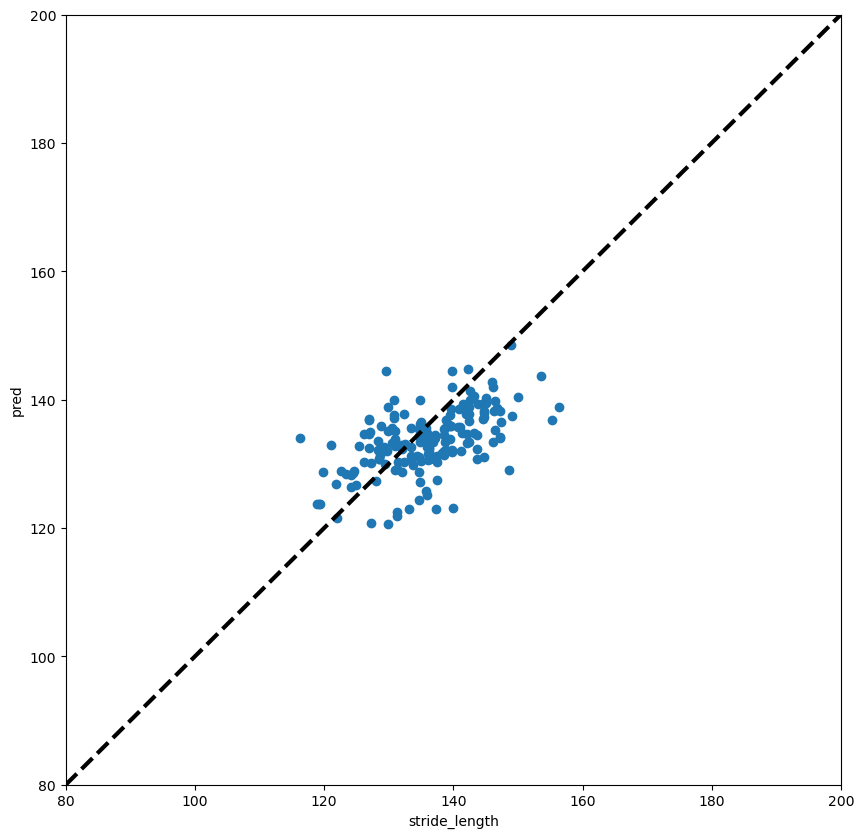

In [7]:
### Scatter Plot 

conv1d_dim1 = 32
conv1d_dim2 = 64
conv1d_dim3 = 128
dense_dim = 256

stride_length_list = pd.DataFrame()
tot_val_MAE = 0
tot_val_MAPE = 0

model_name = './model/pruning/model_origin.pth'

model = Encoder(conv1d_dim1, conv1d_dim2, conv1d_dim3, dense_dim).to(device)
model.load_state_dict(torch.load(model_name)['state_dict'])
# model.load_state_dict(checkpoint['state_dict'])

model.eval()
pred_list = []
for i, data in enumerate(test_loader):
    inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
    inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float() 
    inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

    stride_length = stride_length.reshape(-1, 1)
    stride_length = stride_length.to(device)

    outputs = model(inputs_acc, inputs_gyr, inputs_prs)

pred =  outputs.reshape(-1).cpu().detach().numpy()
stride_length = stride_length.reshape(-1).cpu().detach().numpy()
mu = mu.cpu().detach().numpy()

MAE = np.sum(np.abs(pred - stride_length)) / len(stride_length)
MAPE = 100 - (np.mean(np.abs(pred - stride_length) / stride_length) * 100)
RMSE = np.sqrt(np.mean((stride_length - pred)**2))
RSE = RMSE / np.sqrt(np.sum((stride_length - mu)**2))


print('MAE : {:.4f}, MAPE : {:.2f}%, RMSE : {:.4f}, RSE : {:.4f}'.format(MAE, MAPE, RMSE, RSE))

plt.figure(figsize=(10, 10))
plt.scatter(stride_length, pred)
plt.xlim([80, 200])
plt.xlabel('stride_length')
plt.ylim([80, 200])
plt.ylabel('pred')

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.show()

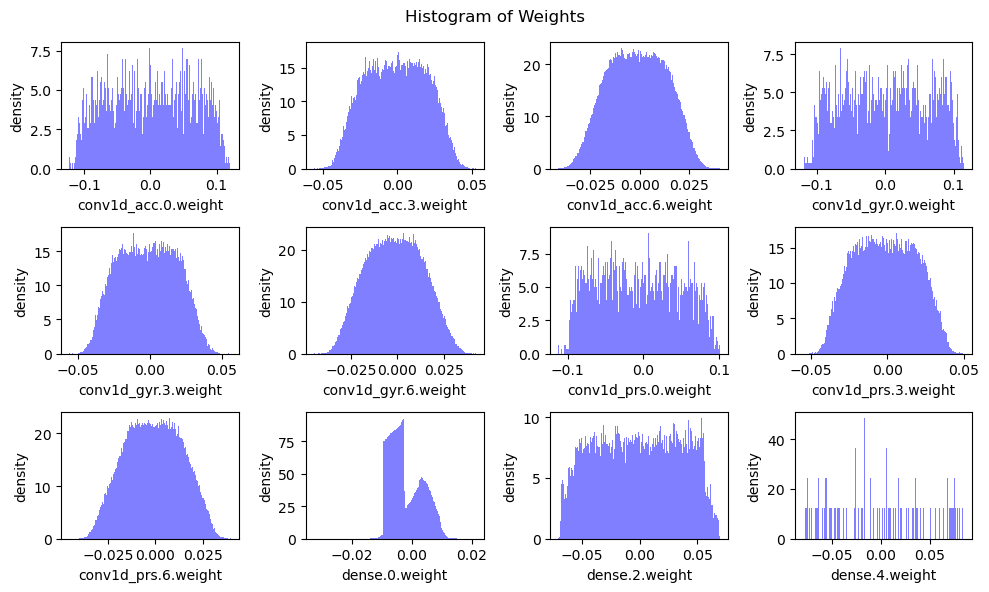

In [9]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,4, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

In [10]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [9]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  extra_preprocess = None
) -> float:
    model.eval()
    
    num_samples = 0
    num_correct = 0

    for i, data in enumerate(dataloader):
        inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
        inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float() 
        inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        outputs = model(inputs_acc, inputs_gyr, inputs_prs)        
        
    pred = outputs.reshape(-1).cpu().detach().numpy()
    stride_length = stride_length.reshape(-1).cpu().detach().numpy()
    mu = mu.cpu().detach().numpy()

    MAE = np.sum(np.abs(pred - stride_length)) / len(stride_length)
    return MAE

In [11]:
dense_model_accuracy = evaluate(model, test_loader)
dense_model_size = get_model_size(model)
print(f"dense model has MAE={dense_model_accuracy:.2f}")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

dense model has MAE=5.71
dense model has size=83.56 MiB


In [ ]:
def train(
    model: nn.Module,
    dataloader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    scheduler: LambdaLR,
    callbacks = None
) -> None:
    
    model.train()

    for i, data in enumerate(dataloader):
        inputs_acc, inputs_gyr, inputs_prs, stride_length, mu, sigma, folder_id = data
        inputs_acc, inputs_gyr, inputs_prs, stride_length = inputs_acc.float(), inputs_gyr.float(), inputs_prs.float(), stride_length.float() 
        inputs_acc, inputs_gyr, inputs_prs = inputs_acc.to(device), inputs_gyr.to(device), inputs_prs.to(device)

        stride_length = stride_length.reshape(-1, 1)
        stride_length = stride_length.to(device)

        outputs = model(inputs_acc, inputs_gyr, inputs_prs)        
        
        loss = criterion(outputs, stride_length)

        # Backward propagation
        loss.backward()

        # Update optimizer and LR scheduler
        optimizer.step()
        scheduler.step()

        if callbacks is not None:
            for callback in callbacks:
                callback()

In [20]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    num_zeros = round(num_elements * sparsity)
    importance =  tensor.abs()
    threshold = importance.view(-1).kthvalue(num_zeros).values.item()
    mask =  importance > threshold

    tensor.mul_(mask)

    return mask


def test_fine_grained_prune(
    test_tensor=torch.Tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.Tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')

In [22]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [36]:
sparsity_dict = {
    'conv1d_acc.0.weight': 0.5,
    'conv1d_acc.1.weight': 0.5,
    'conv1d_acc.3.weight': 0.5,
    'conv1d_acc.4.weight': 0.5,
    'conv1d_acc.6.weight': 0.5,
    'conv1d_acc.7.weight': 0.5,
    'conv1d_gyr.0.weight': 0.5,
    'conv1d_gyr.1.weight': 0.5,
    'conv1d_gyr.3.weight': 0.5,
    'conv1d_gyr.4.weight': 0.5,
    'conv1d_gyr.6.weight': 0.5,
    'conv1d_gyr.7.weight': 0.5,
    'conv1d_prs.0.weight': 0.5,
    'conv1d_prs.1.weight': 0.5,
    'conv1d_prs.3.weight': 0.5,
    'conv1d_prs.4.weight': 0.5,
    'conv1d_prs.6.weight': 0.5,
    'conv1d_prs.7.weight': 0.5,
    'conv1d_prs.6.weight': 0.5,
    'dense.0.weight': 0.2,
    'dense.2.weight': 0.2,
    'dense.4.weight': 0.2,
}

After pruning with sparsity dictionary
  conv1d_acc.0.weight: 0.50
  conv1d_acc.1.weight: 0.50
  conv1d_acc.3.weight: 0.50
  conv1d_acc.4.weight: 0.50
  conv1d_acc.6.weight: 0.50
  conv1d_acc.7.weight: 0.50
  conv1d_gyr.0.weight: 0.50
  conv1d_gyr.1.weight: 0.50
  conv1d_gyr.3.weight: 0.50
  conv1d_gyr.4.weight: 0.50
  conv1d_gyr.6.weight: 0.50
  conv1d_gyr.7.weight: 0.50
  conv1d_prs.0.weight: 0.50
  conv1d_prs.1.weight: 0.50
  conv1d_prs.3.weight: 0.50
  conv1d_prs.4.weight: 0.50
  conv1d_prs.6.weight: 0.50
  conv1d_prs.7.weight: 0.50
  dense.0.weight: 0.20
  dense.2.weight: 0.20
  dense.4.weight: 0.20
The sparsity of each layer becomes
  conv1d_acc.0.weight: 0.50
  conv1d_acc.1.weight: 0.00
  conv1d_acc.3.weight: 0.50
  conv1d_acc.4.weight: 0.00
  conv1d_acc.6.weight: 0.50
  conv1d_acc.7.weight: 0.00
  conv1d_gyr.0.weight: 0.50
  conv1d_gyr.1.weight: 0.00
  conv1d_gyr.3.weight: 0.50
  conv1d_gyr.4.weight: 0.00
  conv1d_gyr.6.weight: 0.50
  conv1d_gyr.7.weight: 0.00
  conv1d_prs.0.we

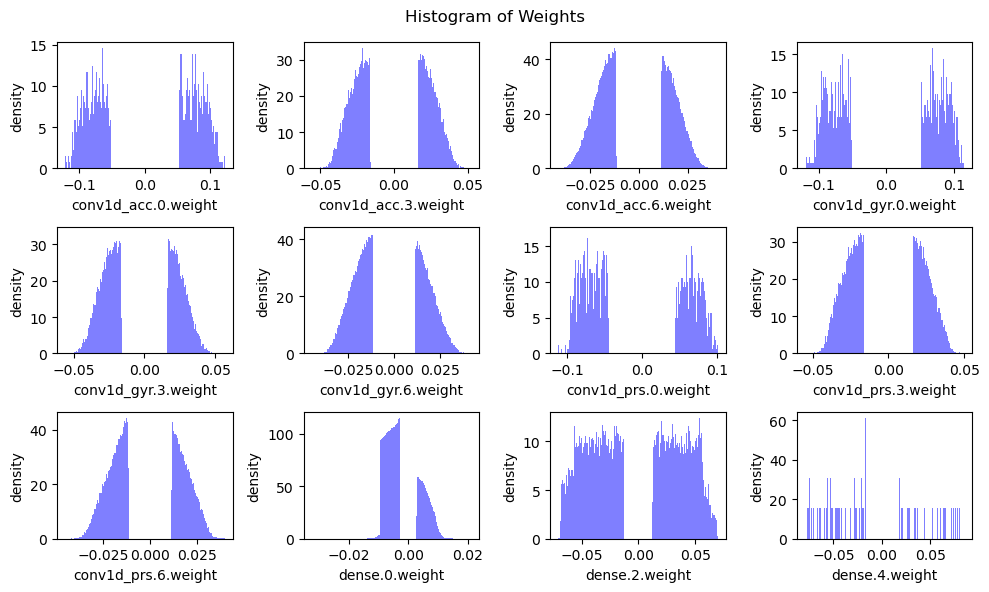

In [38]:
pruner = FineGrainedPruner(model, sparsity_dict)
print(f'After pruning with sparsity dictionary')
for name, sparsity in sparsity_dict.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in sparsity_dict:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, test_loader)
print(f"Sparse model has MAE={sparse_model_accuracy:.2f} before fintuning")

plot_weight_distribution(model, count_nonzero_only=True)